# PANDA End-to-End Modeling

This notebook uses a stratified k-fold split to divide data into 3 seperate pairs of training and validation sets and then uses transfer learning to adapt a pretrained Densenet (161 variant) to the PANDA task.

### Workspace Initialization and Data Setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastbook import *
import pandas as pd
import numpy as np
import pickle
from tqdm.notebook import tqdm
import boto3
import os
import zipfile
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

In [4]:
with open('AWS_creds.json') as f:
    credentials = json.load(f)

s3client = boto3.client('s3',
    aws_access_key_id=credentials['aws_access_key_id'],
    aws_secret_access_key=credentials['aws_secret_access_key'])
bucket = 'kitt-panda-data'

In [24]:
# Download tabular data that was saved with each image/view during the extraction process and organize in a df
data_df = pd.DataFrame()
for part in range(10):
    file_name = f'panda_direct36_ds2_data_{part}.pkl'
    s3client.download_file( bucket,file_name, file_name)
    temp_df = pd.read_pickle(file_name)
    data_df = pd.concat([data_df,temp_df])

data_df.reset_index(inplace=True, drop=True)
print('Data DF shape: ', data_df.shape)
data_df['tile_file'] = data_df['view_id'].apply(lambda x: str(x+'.png'))
data_df.sample(10).head(10)

Data DF shape:  (39240, 7)


,view_id,image_gleason_score,image_isup_grade,image_data_provider,tile_mean,tile_stdev,image_id,tile_file
8306,37b0ce91b7bdaf3100aae1748009424e_view_2,4+3,3,karolinska,"[0.8434691717918521, 0.671811810662333, 0.8017395351979419]","[0.14565905155965395, 0.2608265203121359, 0.1588190616263674]",37b0ce91b7bdaf3100aae1748009424e,37b0ce91b7bdaf3100aae1748009424e_view_2.png
3705,19963a5a3c42675307056e0be36851cf_view_1,4+3,3,radboud,"[0.89463110032685, 0.8080849441850375, 0.8517491558827296]","[0.12432865308639232, 0.19960627964066813, 0.14810731497986476]",19963a5a3c42675307056e0be36851cf,19963a5a3c42675307056e0be36851cf_view_1.png
17650,75cb55b879fce1a96c8273cdd77048c0_view_2,4+4,4,karolinska,"[0.8249140853706655, 0.643652935485496, 0.7877625309569533]","[0.14783017165304885, 0.2618917420035708, 0.15903709258528034]",75cb55b879fce1a96c8273cdd77048c0,75cb55b879fce1a96c8273cdd77048c0_view_2.png
20572,8887984626edc8b93aef010bf8357337_view_0,0+0,0,karolinska,"[0.8297986996712496, 0.6523632041251671, 0.7887867713550217]","[0.1748671511717378, 0.2976569005277704, 0.18551675090726155]",8887984626edc8b93aef010bf8357337,8887984626edc8b93aef010bf8357337_view_0.png
2128,0e5806abc1cf909123d584e504dd9bf9_view_0,5+5,5,radboud,"[0.9937390961159045, 0.9877007910370094, 0.9901572499660527]","[0.030392269221099825, 0.06852196025248797, 0.051792325519762636]",0e5806abc1cf909123d584e504dd9bf9,0e5806abc1cf909123d584e504dd9bf9_view_0.png
33709,dbfc9c44024301555f3cc9118f1f3628_view_1,3+4,2,radboud,"[0.8763889819710733, 0.6680057766647687, 0.7437621804396493]","[0.07322440167473825, 0.1818347747284021, 0.13513576639412272]",dbfc9c44024301555f3cc9118f1f3628,dbfc9c44024301555f3cc9118f1f3628_view_1.png
27241,b29e5425308f0f10cded9bb6c75b6049_view_1,4+4,4,radboud,"[0.964607355122879, 0.9152279922397896, 0.9310960358274775]","[0.07102733233056532, 0.18261557975402518, 0.14281755264113674]",b29e5425308f0f10cded9bb6c75b6049,b29e5425308f0f10cded9bb6c75b6049_view_1.png
15633,68ef1f45254c298cac176cabb6c0fe58_view_1,5+3,4,radboud,"[0.8665224029612193, 0.7087543229934635, 0.7688988180739516]","[0.12639979293426104, 0.2620274484090359, 0.20034866539262838]",68ef1f45254c298cac176cabb6c0fe58,68ef1f45254c298cac176cabb6c0fe58_view_1.png
6152,29b03a7c58dbdb44f46d936788d8eb66_view_0,4+3,3,radboud,"[0.9646066503597327, 0.9269085653473366, 0.9462859376065946]","[0.08299847124705535, 0.15362841624548357, 0.11252604828691308]",29b03a7c58dbdb44f46d936788d8eb66,29b03a7c58dbdb44f46d936788d8eb66_view_0.png
27874,b6808a211b62298e06b0ac7f30f29882_view_2,3+3,1,radboud,"[0.8563842108574797, 0.6777410436562161, 0.7466185127231483]","[0.1510010728289641, 0.1868216246547745, 0.16024971798562992]",b6808a211b62298e06b0ac7f30f29882,b6808a211b62298e06b0ac7f30f29882_view_2.png


In [6]:
# Since there are 4 views for each individual sample and it would not be valid to have some views of a sample in the 
# training set and other views in the validation set we must first isolate the unique sample IDs present. Once we 
# have those we can use a stratified k-fold split to preserve the rations of ISUP scores across train and validation.
# Finally we can translate those indices back to the indices for all views of the sample splits 
split_df = data_df[['image_id','image_gleason_score','image_isup_grade','image_data_provider']].drop_duplicates()
split_df.reset_index(drop=True,inplace=True)
skf = StratifiedKFold(n_splits=6, random_state=5, shuffle=True)
# Though we will only be training 3 models at this time I typically find using 5+ folds to be ideal
strat_split1,strat_split2,strat_split3,_,_,_ = skf.split(split_df.image_id,split_df.image_isup_grade)

Text(0.5, 1.0, 'Validation Set Image Count by Data Provider')

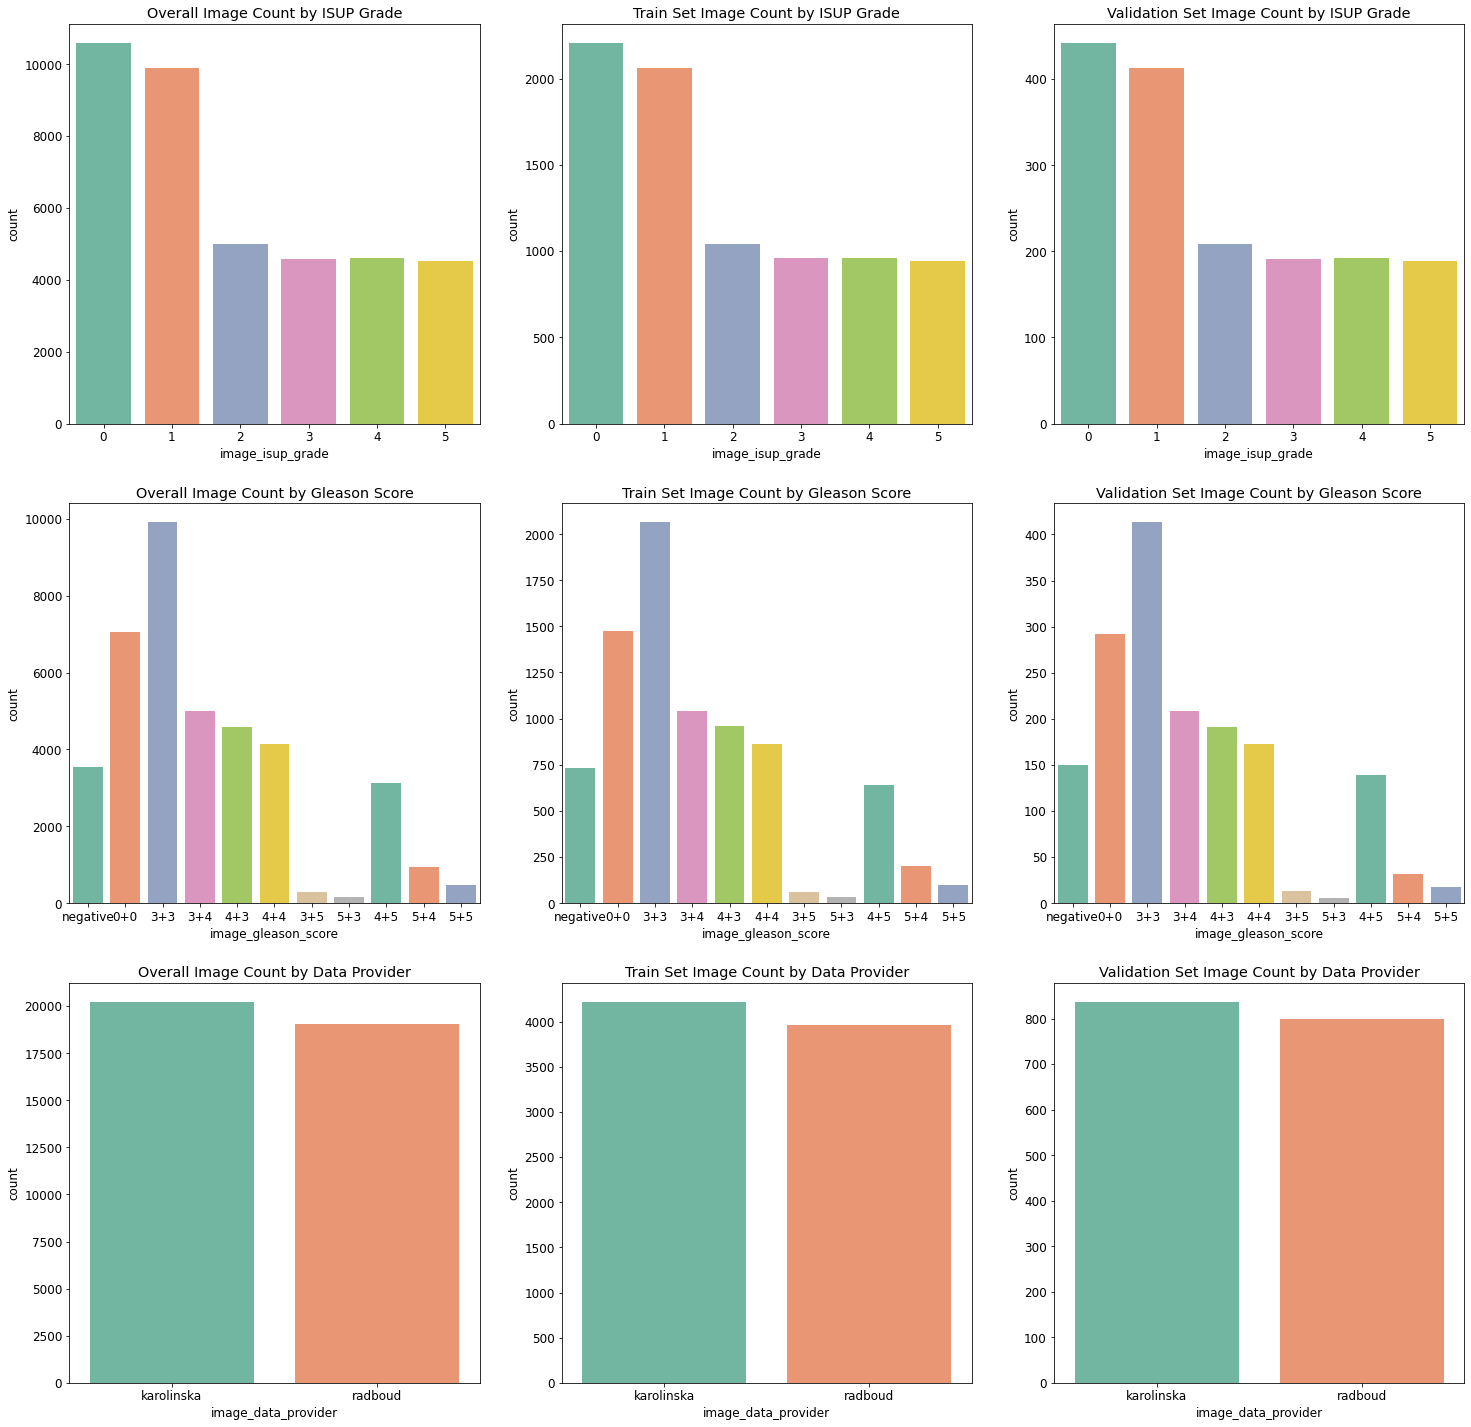

In [7]:
# Examine the first fold for balance
fig,axs = plt.subplots(3,3,figsize=(25,25))
sns.countplot(ax=axs[0,0], x=data_df['image_isup_grade'],order = [0,1,2,3,4,5], palette='Set2')
axs[0,0].set_title('Overall Image Count by ISUP Grade');
sns.countplot(ax=axs[0,1], x=split_df.iloc[list(strat_split1[0]),2],order = [0,1,2,3,4,5], palette='Set2')
axs[0,1].set_title('Train Set Image Count by ISUP Grade');
sns.countplot(ax=axs[0,2], x=split_df.iloc[list(strat_split1[1]),2],order = [0,1,2,3,4,5], palette='Set2')
axs[0,2].set_title('Validation Set Image Count by ISUP Grade');

sns.countplot(ax=axs[1,0], x=data_df['image_gleason_score'],order = ['negative', '0+0','3+3','3+4','4+3','4+4',
                                                                     '3+5','5+3','4+5','5+4','5+5' ], palette='Set2')
axs[1,0].set_title('Overall Image Count by Gleason Score');
sns.countplot(ax=axs[1,1], x=split_df.iloc[list(strat_split1[0]),1],order = ['negative', '0+0','3+3','3+4','4+3','4+4',
                                                                             '3+5','5+3','4+5','5+4','5+5' ], palette='Set2')
axs[1,1].set_title('Train Set Image Count by Gleason Score');
sns.countplot(ax=axs[1,2], x=split_df.iloc[list(strat_split1[1]),1],order = ['negative', '0+0','3+3','3+4','4+3','4+4',
                                                                             '3+5','5+3','4+5','5+4','5+5' ], palette='Set2')
axs[1,2].set_title('Validation Set Image Count by Gleason Score');

sns.countplot(ax=axs[2,0], x=data_df['image_data_provider'], palette='Set2')
axs[2,0].set_title('Overall Image Count by Data Provider');
sns.countplot(ax=axs[2,1], x=split_df.iloc[list(strat_split1[0]),3], palette='Set2')
axs[2,1].set_title('Train Set Image Count by Data Provider');
sns.countplot(ax=axs[2,2], x=split_df.iloc[list(strat_split1[1]),3], palette='Set2')
axs[2,2].set_title('Validation Set Image Count by Data Provider');

Text(0.5, 1.0, 'Validation Set Image Count by Data Provider')

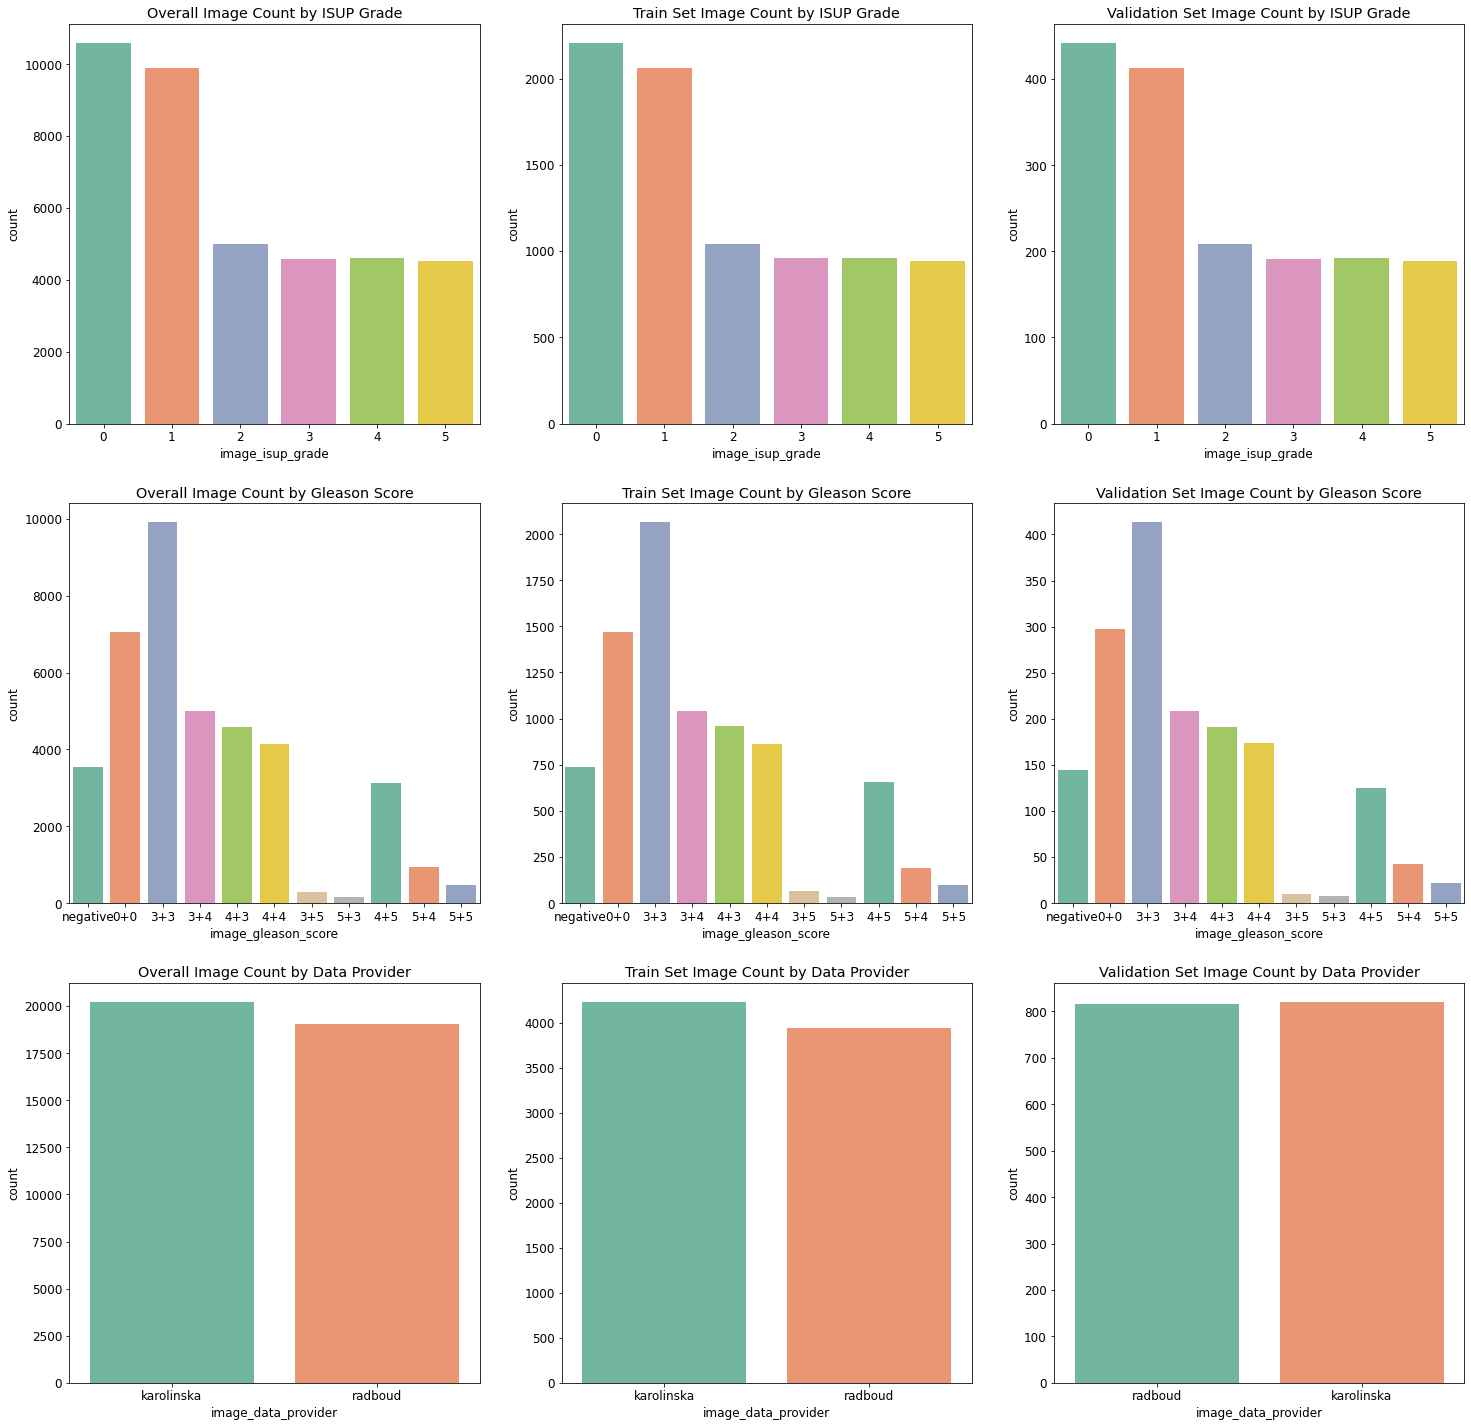

In [8]:
# Examine the second fold for balance
fig,axs = plt.subplots(3,3,figsize=(25,25))
sns.countplot(ax=axs[0,0], x=data_df['image_isup_grade'],order = [0,1,2,3,4,5], palette='Set2')
axs[0,0].set_title('Overall Image Count by ISUP Grade');
sns.countplot(ax=axs[0,1], x=split_df.iloc[list(strat_split2[0]),2],order = [0,1,2,3,4,5], palette='Set2')
axs[0,1].set_title('Train Set Image Count by ISUP Grade');
sns.countplot(ax=axs[0,2], x=split_df.iloc[list(strat_split2[1]),2],order = [0,1,2,3,4,5], palette='Set2')
axs[0,2].set_title('Validation Set Image Count by ISUP Grade');

sns.countplot(ax=axs[1,0], x=data_df['image_gleason_score'],order = ['negative', '0+0','3+3','3+4','4+3','4+4',
                                                                     '3+5','5+3','4+5','5+4','5+5' ], palette='Set2')
axs[1,0].set_title('Overall Image Count by Gleason Score');
sns.countplot(ax=axs[1,1], x=split_df.iloc[list(strat_split2[0]),1],order = ['negative', '0+0','3+3','3+4','4+3','4+4',
                                                                             '3+5','5+3','4+5','5+4','5+5' ], palette='Set2')
axs[1,1].set_title('Train Set Image Count by Gleason Score');
sns.countplot(ax=axs[1,2], x=split_df.iloc[list(strat_split2[1]),1],order = ['negative', '0+0','3+3','3+4','4+3','4+4',
                                                                             '3+5','5+3','4+5','5+4','5+5' ], palette='Set2')
axs[1,2].set_title('Validation Set Image Count by Gleason Score');

sns.countplot(ax=axs[2,0], x=data_df['image_data_provider'], palette='Set2')
axs[2,0].set_title('Overall Image Count by Data Provider');
sns.countplot(ax=axs[2,1], x=split_df.iloc[list(strat_split2[0]),3], palette='Set2')
axs[2,1].set_title('Train Set Image Count by Data Provider');
sns.countplot(ax=axs[2,2], x=split_df.iloc[list(strat_split2[1]),3], palette='Set2')
axs[2,2].set_title('Validation Set Image Count by Data Provider');

Text(0.5, 1.0, 'Validation Set Image Count by Data Provider')

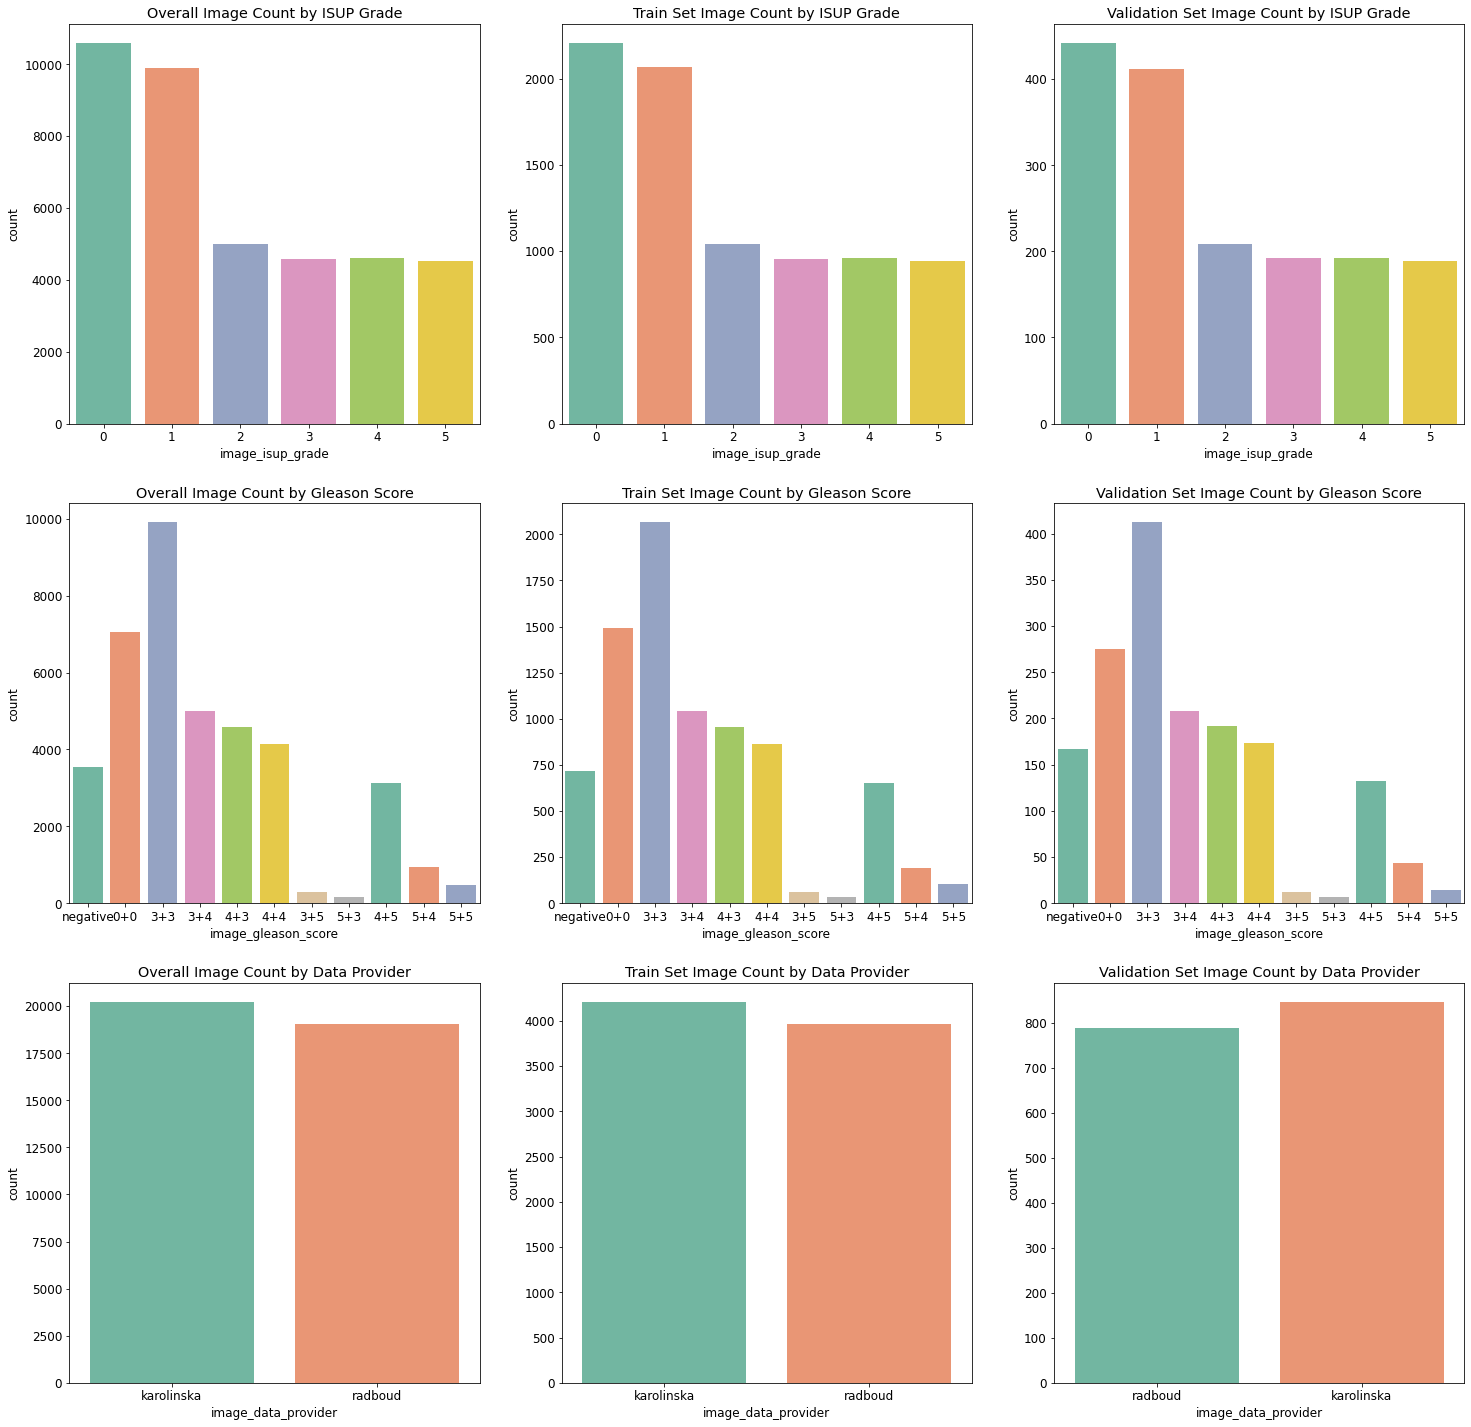

In [9]:
# Examine the third fold for balance
fig,axs = plt.subplots(3,3,figsize=(25,25))
sns.countplot(ax=axs[0,0], x=data_df['image_isup_grade'],order = [0,1,2,3,4,5], palette='Set2')
axs[0,0].set_title('Overall Image Count by ISUP Grade');
sns.countplot(ax=axs[0,1], x=split_df.iloc[list(strat_split3[0]),2],order = [0,1,2,3,4,5], palette='Set2')
axs[0,1].set_title('Train Set Image Count by ISUP Grade');
sns.countplot(ax=axs[0,2], x=split_df.iloc[list(strat_split3[1]),2],order = [0,1,2,3,4,5], palette='Set2')
axs[0,2].set_title('Validation Set Image Count by ISUP Grade');

sns.countplot(ax=axs[1,0], x=data_df['image_gleason_score'],order = ['negative', '0+0','3+3','3+4','4+3','4+4',
                                                                     '3+5','5+3','4+5','5+4','5+5' ], palette='Set2')
axs[1,0].set_title('Overall Image Count by Gleason Score');
sns.countplot(ax=axs[1,1], x=split_df.iloc[list(strat_split3[0]),1],order = ['negative', '0+0','3+3','3+4','4+3','4+4',
                                                                             '3+5','5+3','4+5','5+4','5+5' ], palette='Set2')
axs[1,1].set_title('Train Set Image Count by Gleason Score');
sns.countplot(ax=axs[1,2], x=split_df.iloc[list(strat_split3[1]),1],order = ['negative', '0+0','3+3','3+4','4+3','4+4',
                                                                             '3+5','5+3','4+5','5+4','5+5' ], palette='Set2')
axs[1,2].set_title('Validation Set Image Count by Gleason Score');

sns.countplot(ax=axs[2,0], x=data_df['image_data_provider'], palette='Set2')
axs[2,0].set_title('Overall Image Count by Data Provider');
sns.countplot(ax=axs[2,1], x=split_df.iloc[list(strat_split3[0]),3], palette='Set2')
axs[2,1].set_title('Train Set Image Count by Data Provider');
sns.countplot(ax=axs[2,2], x=split_df.iloc[list(strat_split3[1]),3], palette='Set2')
axs[2,2].set_title('Validation Set Image Count by Data Provider');

In [10]:
# Convert split indices to data_df indices to make validation set out of all views of the selected samples
valid_idxs1 = list(data_df.loc[data_df['image_id'].isin(list(split_df.iloc[list(strat_split1[1]),0]))].index)
valid_idxs2 = list(data_df.loc[data_df['image_id'].isin(list(split_df.iloc[list(strat_split2[1]),0]))].index)
valid_idxs3 = list(data_df.loc[data_df['image_id'].isin(list(split_df.iloc[list(strat_split3[1]),0]))].index)
# 9810 unique samples / 6 folds = 1635 validation samples per fold * 4 views per sample = 6540 images per index list 
print(len(valid_idxs1),len(valid_idxs2),len(valid_idxs3))

6540 6540 6540


In [11]:
# Calculate mean and stdev of per channel pixel values for the dataset for normalization
set_mean = np.array(data_df['tile_mean']).mean(0)
set_mean

array([0.85780565, 0.70644778, 0.8043354 ])

In [12]:
set_stdev = np.sqrt((np.array(data_df['tile_stdev'])**2).mean(0))
set_stdev

array([0.13791688, 0.24553864, 0.1628726 ])

In [13]:
# Reduce the dataframe to just image_id (input) and image_isup_grade (target) columns 
train_df = data_df[['tile_file','image_isup_grade']]
print('Train dataframe shape: ',train_df.shape)
train_df.reset_index(inplace=True, drop=True)
train_df.head()

Train dataframe shape:  (39240, 2)


,tile_file,image_isup_grade
0,000920ad0b612851f8e01bcc880d9b3d_view_0.png,0
1,000920ad0b612851f8e01bcc880d9b3d_view_1.png,0
2,000920ad0b612851f8e01bcc880d9b3d_view_2.png,0
3,000920ad0b612851f8e01bcc880d9b3d_view_3.png,0
4,0018ae58b01bdadc8e347995b69f99aa_view_0.png,4


In [14]:
# Recreate a training_df for each fold with a column used as a flag for the validation set to be passed to the DataLoaders
fold1_train_df = train_df.copy()
fold1_train_df['is_valid'] = [0]*len(fold1_train_df)
fold1_train_df.loc[valid_idxs1,'is_valid'] = 1

# I find that balancing classes in the training set leads to better performance so that the while leaving the validation set in its stratified balance
fold1_train_df = pd.concat([
    fold1_train_df.loc[((fold1_train_df['image_isup_grade']==0)&(fold1_train_df['is_valid']==0))],
    fold1_train_df.loc[((fold1_train_df['image_isup_grade']==1)&(fold1_train_df['is_valid']==0))],
    fold1_train_df.loc[((fold1_train_df['image_isup_grade']==2)&(fold1_train_df['is_valid']==0))],
    fold1_train_df.loc[((fold1_train_df['image_isup_grade']==2)&(fold1_train_df['is_valid']==0))],
    fold1_train_df.loc[((fold1_train_df['image_isup_grade']==3)&(fold1_train_df['is_valid']==0))],
    fold1_train_df.loc[((fold1_train_df['image_isup_grade']==3)&(fold1_train_df['is_valid']==0))],
    fold1_train_df.loc[((fold1_train_df['image_isup_grade']==3)&(fold1_train_df['is_valid']==0))].sample(1000),
    fold1_train_df.loc[((fold1_train_df['image_isup_grade']==4)&(fold1_train_df['is_valid']==0))],
    fold1_train_df.loc[((fold1_train_df['image_isup_grade']==4)&(fold1_train_df['is_valid']==0))],
    fold1_train_df.loc[((fold1_train_df['image_isup_grade']==4)&(fold1_train_df['is_valid']==0))].sample(1000),
    fold1_train_df.loc[((fold1_train_df['image_isup_grade']==5)&(fold1_train_df['is_valid']==0))],
    fold1_train_df.loc[((fold1_train_df['image_isup_grade']==5)&(fold1_train_df['is_valid']==0))],
    fold1_train_df.loc[((fold1_train_df['image_isup_grade']==5)&(fold1_train_df['is_valid']==0))].sample(1000),
    fold1_train_df.loc[fold1_train_df['is_valid']==1]
                        ])

fold2_train_df = train_df.copy()
fold2_train_df['is_valid'] = [0]*len(fold2_train_df)
fold2_train_df.loc[valid_idxs2,'is_valid'] = 1
fold2_train_df = pd.concat([
    fold2_train_df.loc[((fold2_train_df['image_isup_grade']==0)&(fold2_train_df['is_valid']==0))],
    fold2_train_df.loc[((fold2_train_df['image_isup_grade']==1)&(fold2_train_df['is_valid']==0))],
    fold2_train_df.loc[((fold2_train_df['image_isup_grade']==2)&(fold2_train_df['is_valid']==0))],
    fold2_train_df.loc[((fold2_train_df['image_isup_grade']==2)&(fold2_train_df['is_valid']==0))],
    fold2_train_df.loc[((fold2_train_df['image_isup_grade']==3)&(fold2_train_df['is_valid']==0))],
    fold2_train_df.loc[((fold2_train_df['image_isup_grade']==3)&(fold2_train_df['is_valid']==0))],
    fold2_train_df.loc[((fold2_train_df['image_isup_grade']==3)&(fold2_train_df['is_valid']==0))].sample(1000),
    fold2_train_df.loc[((fold2_train_df['image_isup_grade']==4)&(fold2_train_df['is_valid']==0))],
    fold2_train_df.loc[((fold2_train_df['image_isup_grade']==4)&(fold2_train_df['is_valid']==0))],
    fold2_train_df.loc[((fold2_train_df['image_isup_grade']==4)&(fold2_train_df['is_valid']==0))].sample(1000),
    fold2_train_df.loc[((fold2_train_df['image_isup_grade']==5)&(fold2_train_df['is_valid']==0))],
    fold2_train_df.loc[((fold2_train_df['image_isup_grade']==5)&(fold2_train_df['is_valid']==0))],
    fold2_train_df.loc[((fold2_train_df['image_isup_grade']==5)&(fold2_train_df['is_valid']==0))].sample(1000),
    fold2_train_df.loc[fold2_train_df['is_valid']==1]
                        ])

fold3_train_df = train_df.copy()
fold3_train_df['is_valid'] = [0]*len(fold3_train_df)
fold3_train_df.loc[valid_idxs3,'is_valid'] = 1
fold3_train_df = pd.concat([
    fold3_train_df.loc[((fold3_train_df['image_isup_grade']==0)&(fold3_train_df['is_valid']==0))],
    fold3_train_df.loc[((fold3_train_df['image_isup_grade']==1)&(fold3_train_df['is_valid']==0))],
    fold3_train_df.loc[((fold3_train_df['image_isup_grade']==2)&(fold3_train_df['is_valid']==0))],
    fold3_train_df.loc[((fold3_train_df['image_isup_grade']==2)&(fold3_train_df['is_valid']==0))],
    fold3_train_df.loc[((fold3_train_df['image_isup_grade']==3)&(fold3_train_df['is_valid']==0))],
    fold3_train_df.loc[((fold3_train_df['image_isup_grade']==3)&(fold3_train_df['is_valid']==0))],
    fold3_train_df.loc[((fold3_train_df['image_isup_grade']==3)&(fold3_train_df['is_valid']==0))].sample(1000),
    fold3_train_df.loc[((fold3_train_df['image_isup_grade']==4)&(fold3_train_df['is_valid']==0))],
    fold3_train_df.loc[((fold3_train_df['image_isup_grade']==4)&(fold3_train_df['is_valid']==0))],
    fold3_train_df.loc[((fold3_train_df['image_isup_grade']==4)&(fold3_train_df['is_valid']==0))].sample(1000),
    fold3_train_df.loc[((fold3_train_df['image_isup_grade']==5)&(fold3_train_df['is_valid']==0))],
    fold3_train_df.loc[((fold3_train_df['image_isup_grade']==5)&(fold3_train_df['is_valid']==0))],
    fold3_train_df.loc[((fold3_train_df['image_isup_grade']==5)&(fold3_train_df['is_valid']==0))].sample(1000),
    fold3_train_df.loc[fold3_train_df['is_valid']==1]
                        ])

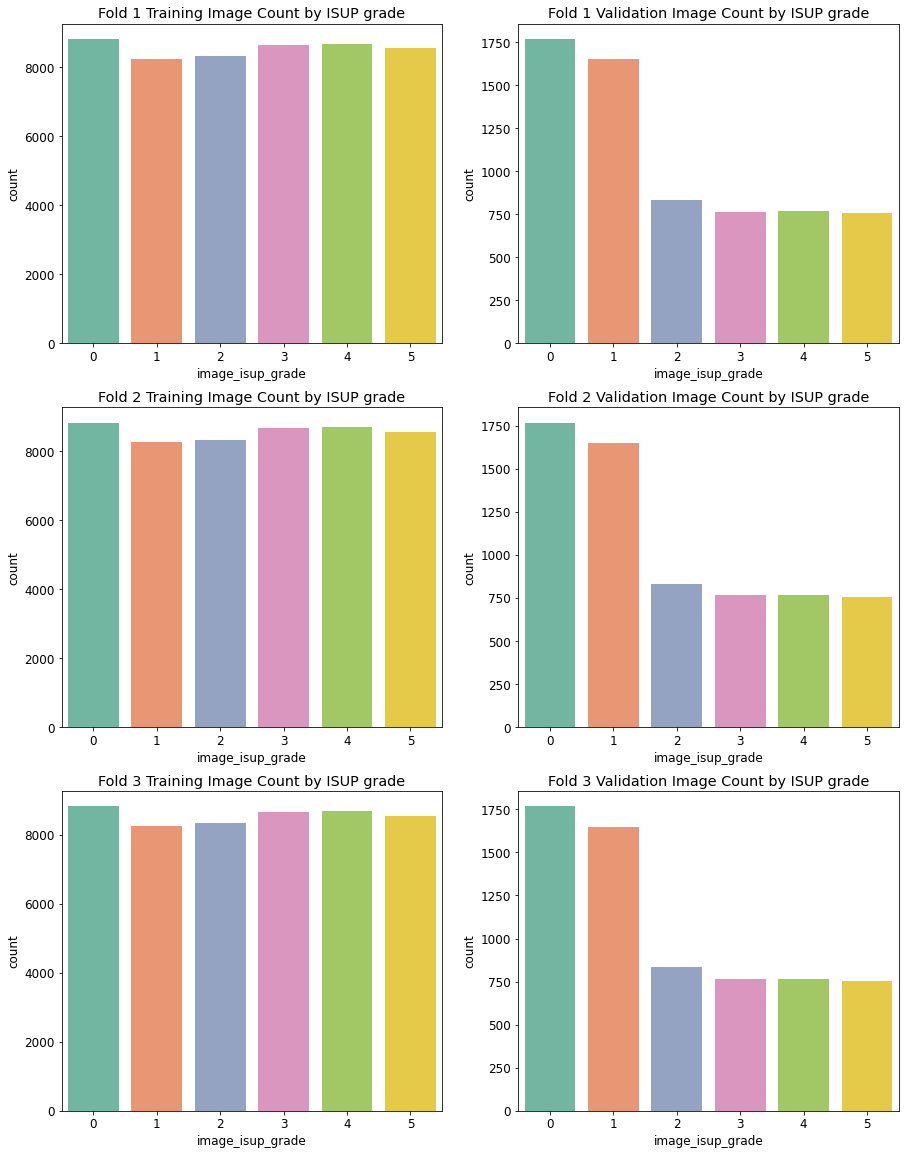

In [15]:
fig,axs = plt.subplots(3,2,figsize=(15,20))
sns.countplot(ax=axs[0,0],x = fold1_train_df.loc[fold1_train_df['is_valid']==0,'image_isup_grade'],
              order = [0,1,2,3,4,5],
              palette='Set2')
axs[0,0].set_title('Fold 1 Training Image Count by ISUP grade');
sns.countplot(ax=axs[0,1],x = fold1_train_df.loc[fold1_train_df['is_valid']==1,'image_isup_grade'],
              order = [0,1,2,3,4,5], 
              palette='Set2')
axs[0,1].set_title('Fold 1 Validation Image Count by ISUP grade');
                   
sns.countplot(ax=axs[1,0],x = fold2_train_df.loc[fold2_train_df['is_valid']==0,'image_isup_grade'],
              order = [0,1,2,3,4,5],
              palette='Set2')
axs[1,0].set_title('Fold 2 Training Image Count by ISUP grade');
sns.countplot(ax=axs[1,1],x = fold2_train_df.loc[fold2_train_df['is_valid']==1,'image_isup_grade'],
              order = [0,1,2,3,4,5], 
              palette='Set2')
axs[1,1].set_title('Fold 2 Validation Image Count by ISUP grade');
sns.countplot(ax=axs[2,0],x = fold3_train_df.loc[fold3_train_df['is_valid']==0,'image_isup_grade'],
              order = [0,1,2,3,4,5],
              palette='Set2')
axs[2,0].set_title('Fold 3 Training Image Count by ISUP grade');
sns.countplot(ax=axs[2,1],x = fold3_train_df.loc[fold3_train_df['is_valid']==1,'image_isup_grade'],
              order = [0,1,2,3,4,5], 
              palette='Set2')
axs[2,1].set_title('Fold 3 Validation Image Count by ISUP grade');

In [ ]:
os.mkdir('images')
for part in range(10):   
    file_name = f'panda_direct36_ds2_imgs_{part}.zip'
    s3client.download_file( bucket,file_name, file_name)  
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall('images')
    os.remove(file_name)

### Create and Train Models

In [16]:
def get_dls(bs,size,df):
    """Function for easy creation of ImageDataLoaders
    """
    return ImageDataLoaders.from_df(df, path='.', fn_col='tile_file', folder='images', label_col='image_isup_grade', 
                                    valid_col = 'is_valid', 
                                    batch_tfms=[
                                        *aug_transforms(do_flip=True,flip_vert=True,max_rotate=5.0,max_lighting=0.05,
                                        min_zoom=0.97,max_zoom=1.03,max_warp=0.0,size=size),
                                        Normalize.from_stats(torch.Tensor(set_mean), torch.Tensor(set_stdev))], 
                                     bs=bs)

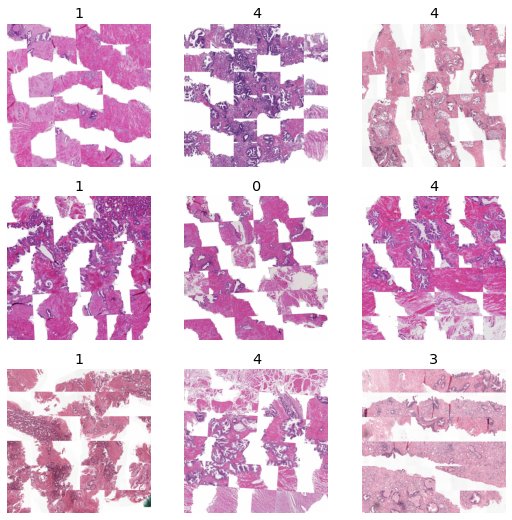

In [17]:
# Create a batch from the data loader and do a visual check
dls1 = get_dls(9,768,fold1_train_df)
dls1.show_batch(nrows=3,ncols=3)

In [18]:
# Check that normalization was done correctly and the batch channel means and standard deviations are close to [0,1]
x,y = dls1.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([0.0989, 0.1542, 0.1566], device='cuda:0'),
 TensorImage([0.9758, 0.9822, 0.9679], device='cuda:0'))

In [19]:
# In my experience densenets work particularly well for medical images, likely due to the fact that they feed forward the
# low-level features which should aid in picking up relatively simple patterns and shapes as opposed to dog/cat, cars, etc.
# that you find in more generalized tasks like ImageNet
kappa = CohenKappa(weights='quadratic')
panda_learner = cnn_learner(dls=dls1,
                        arch=models.densenet161,
                        pretrained=True,
                        normalize=False,
                        metrics=[accuracy,kappa],
                        loss_func=LabelSmoothingCrossEntropy(),
                        opt_func=ranger,
                        n_out=6,wd=0.0001,ps=0.3,
                        ).to_fp16()

In [20]:
# Flat -> cosine anneal is the prefered lr schedule for the ranger optimizer due to its built in warmup period and Lookahead
# Starting with a relatively large learning rate also tends to help generalization/overfitting as it helps to pick up 
# "large"/simple features first before moving on to more complex/fine features as the lr is annealed
panda_learner.fit_flat_cos(1, lr=5e-3, div_final=500, pct_start=0.10,wd=1e-4)

epoch,train_loss,valid_loss,accuracy,cohen_kappa_score,time
0,1.242077,1.106157,0.651376,0.780700,48:13


In [21]:
panda_learner.save('direct36_densenet_pt_head_1')
panda_learner.export('direct36_densenet_pt_head_1.pkl')

In [22]:
panda_learner.unfreeze()
panda_learner.fit_flat_cos(2, lr=2e-5, div_final=2000, pct_start=0.05,wd=1e-4,
                           cbs=SaveModelCallback(monitor='cohen_kappa_score', fname='direct36_densenet_pt_full_cb_1',
                                                 every_epoch=False))

epoch,train_loss,valid_loss,accuracy,cohen_kappa_score,time
0,1.153704,1.061989,0.674312,0.806524,1:00:45
1,1.157042,1.071688,0.666972,0.807307,1:01:00


Better model found at epoch 0 with cohen_kappa_score value: 0.8065237129382984.
Better model found at epoch 1 with cohen_kappa_score value: 0.8073067664971944.


In [23]:
panda_learner.save('direct36_densenet_pt_full_1')
panda_learner.export('direct36_densenet_pt_full_1.pkl')

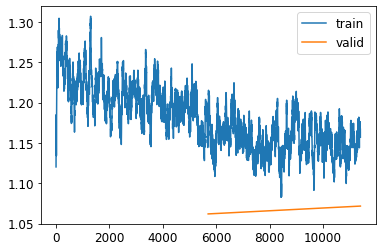

In [25]:
panda_learner.recorder.plot_loss()

In [ ]:
del panda_learner
torch.cuda.empty_cache()

In [16]:
dls2 = get_dls(9,768,fold2_train_df)

In [17]:
kappa = CohenKappa(weights='quadratic')
panda_learner2 = cnn_learner(dls=dls2,
                        arch=models.densenet161,
                        pretrained=True,
                        normalize=False,
                        metrics=[accuracy,kappa],
                        loss_func=LabelSmoothingCrossEntropy(),
                        opt_func=ranger,
                        n_out=6,wd=0.0001,ps=0.3,
                        ).to_fp16()

In [20]:
panda_learner2.fit_flat_cos(1, lr=5e-3, div_final=500, pct_start=0.10,wd=1e-4)

epoch,train_loss,valid_loss,accuracy,cohen_kappa_score,time
0,1.240770,1.109187,0.652599,0.791912,48:13


In [21]:
panda_learner2.save('direct36_densenet_pt_head_2')
panda_learner2.export('direct36_densenet_pt_head_2.pkl')

In [23]:
panda_learner2.unfreeze()
panda_learner2.fit_flat_cos(2, lr=2e-5, div_final=2000, pct_start=0.05,wd=1e-4,
                           cbs=SaveModelCallback(monitor='cohen_kappa_score', fname='direct36_densenet_pt_full_cb_2',
                                                 every_epoch=False))

epoch,train_loss,valid_loss,accuracy,cohen_kappa_score,time
0,1.173677,1.078674,0.675535,0.820607,1:00:54
1,1.111530,1.059155,0.688532,0.819098,1:00:58


Better model found at epoch 0 with cohen_kappa_score value: 0.8206068656925121.


In [24]:
panda_learner2.save('direct36_densenet_pt_full_2')
panda_learner2.export('direct36_densenet_pt_full_2.pkl')

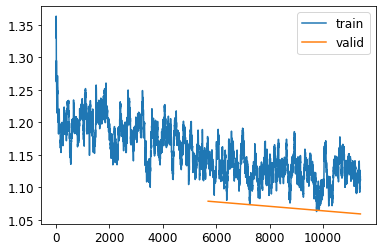

In [25]:
panda_learner2.recorder.plot_loss()

In [ ]:
del panda_learner2
torch.cuda.empty_cache()

In [ ]:
dls3 = get_dls(9,768,fold3_train_df)

kappa = CohenKappa(weights='quadratic')
panda_learner3 = cnn_learner(dls=dls3,
                        arch=models.densenet161,
                        pretrained=True,
                        normalize=False,
                        metrics=[accuracy,kappa],
                        loss_func=LabelSmoothingCrossEntropy(),
                        opt_func=ranger,
                        n_out=6,wd=0.0001,ps=0.2,
                        ).to_fp16()

panda_learner3.fit_flat_cos(1, lr=5e-3, div_final=500, pct_start=0.10,wd=1e-4)
panda_learner3.save('direct36_densenet_pt_head_3')
panda_learner3.export('direct36_densenet_pt_head_3.pkl')

panda_learner3.unfreeze()
panda_learner3.fit_flat_cos(3, lr=2e-5, div_final=20000, pct_start=0.05,wd=1e-4,
                           cbs=SaveModelCallback(monitor='cohen_kappa_score', fname='direct36_densenet_pt_full_cb_3',
                                                 every_epoch=False))

panda_learner3.save('direct36_densenet_pt_full_3')
panda_learner3.export('direct36_densenet_pt_full_3.pkl')

In [ ]:
# Move saved models over to S3 storage
for mod in os.listdir('./models'):
    file_name = f'models/{mod}'
    s3client.upload_file(file_name, bucket, file_name)

for export in ['direct36_densenet_pt_full_1.pkl','direct36_densenet_pt_full_2.pkl','direct36_densenet_pt_full_3.pkl']:
    s3client.upload_file(export, bucket, export)